# Sheet 4
## 1 Bayes: Signal or Noise?
We know $p(\text{A}|\text{B})=\frac{p(\text{B}|\text{A})p(\text{A})}{p(\text{B})}$. If we assign A=target direction/not on target, B=gamma/background, we see that:
$$p(\text{gamma ray}|\text{target direction})=\frac{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})}{p(\text{target direction})}=\frac{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})}{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})+p(\text{target direction}|\text{background})\cdot p(\text{background}}=\frac{0.95\cdot0.1}{0.95\cdot0.1+ 0.1\cdot0.9}=\frac{0.095}{0.095+0.09}=\frac{0.095}{0.185}\approx0.51=51\%.$$

## 2 Bayes Classifiers

## 3 K-Nearest Neighbors: Cross-Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

load the data

In [94]:
# for faster runtimes, we use a subsampled version of the data even as the 'full' dataset
full_features = np.load('data/dijet_features_normalized.npy')[:,::2]#there was a missing ":," in given code
full_labels = np.load('data/dijet_labels.npy')[::2]

dset_full = (full_features, full_labels) 
dset_medium = (full_features[:, ::4], full_labels[::4])
dset_small = (full_features[:, ::16], full_labels[::16])
dsets = (dset_small, dset_medium, dset_full)

for features, labels in dsets:
    print(features.shape, labels.shape, features.dtype, labels.dtype)

(116, 70) (70,) float64 float64
(116, 280) (280,) float64 float64
(116, 1117) (1117,) float64 float64


(a)

In [95]:
def crossval_splits(features, labels, k):
    """
    compute k-fold cross-validation splits of the features and corresponding labels
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (d, N).
    labels : np.ndarray
        Label array of shape (N).
    k : int
        Number of folds.
        
    Returns
    -------
    list
        A list of the cross validation splits, i.e. a list splits of length n
        splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i)).
        
    """
    assert features.shape[-1] == len(labels), f'Shape mismatch: {features.shape}, {labels.shape}'
    
    # TODO: divide features and labels into (approximately) equal sized chunks
    # Hint: Use np.linspace to get chunk borders and round the results
    split_indices = np.linspace(0,features.shape[-1],k, endpoint=False, dtype=int)[1:]
    # np.array_split returns a python list. For easier concatenation of the arrays in this list
    # (minus the training set), we need them a numpy array. Because the arrays returned by
    # np.array_split may have different lengths, we add dtype=object to avoid a numpy warning
    # and explicitly state that having featuresplits and labelsplits as a "ragged array" is intended
    featuresplits = np.array_split(features, split_indices, axis=1)
    labelsplits   = np.array_split(labels, split_indices)
    # TODO: Shuffle the data
    
    # TODO: Construct a list consisting of the splits; each split consits of 
    #       - the validation set (one chunk of the features and corresponding labels) 
    #       - the training training set (concatenation of all feature and label chunks not used for validation)
    # i.e. splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i))
    splits = []
    for i in range(k):
        #copy = featuresplits.copy()
        retf = np.empty((full_features.shape[0],0))
        retl = np.empty(0)
        for j in range(k):
            if j != i:
                retf = np.append(retf, featuresplits[j],axis=1)
                retl = np.append(retl, labelsplits[j])
        item = [retf, retl,featuresplits[i], labelsplits[i]]
                #np.concatenate(labelsplits[np.arange(len(labelsplits))!=i]),
                #featuresplits[i], labelsplits[i]]
        splits.append(item)
    assert len(splits) == k, f'Got incorrect number of splits: {len(splits)=}!={k=}'
    return splits


In [50]:
split_indices = np.linspace(0,np.shape(full_features)[-1],5, endpoint=False, dtype=int)[1:]
labelsplits   = np.array_split(full_features, split_indices, axis=1)
    # TODO: Shuffle the data
for ft in labelsplits:
    print(ft.shape)
    # TODO: Construct a list consisting of the splits; each split consits of 
    #       - the validation set (one chunk of the features and corresponding labels) 
    #       - the training training set (concatenation of all feature and label chunks not used for validation)
    # i.e. splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i))
#splits = []
#for i in range(k):
copy = labelsplits.copy()
copy.pop(2)
#cp = np.asanyarray(copy, dtype=object)
print(' ')
ret = np.empty((full_features.shape[0],0))
for ft in copy:
    ret = np.append(ret, ft,axis=1)

print(ret.shape)
#np.concatenate(labelsplits).shape
#(np.arange(len(labelsplits))!=3).astype(int)

(116, 223)
(116, 223)
(116, 224)
(116, 223)
(116, 224)
 
(116, 893)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 223 and the array at index 2 has size 224

In [80]:
it = crossval_splits(full_features, full_labels, 5)
print(np.shape(it[0][3]))

(116, 223)
(116, 223)
(116, 224)
(116, 223)
(116, 224)
(223,)


(b)

In [52]:
def mean_err(pred, labels):
    """mean error between categorical predictions and labels (each a 1D numpy array)"""
    # TODO implement this (Hint: compute the mean over a fitting boolean array)
    err = np.mean(np.abs((pred-labels).astype(int)))
    return err

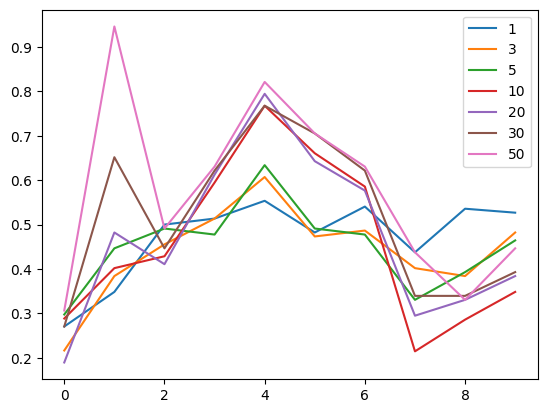

In [96]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((n_folds, len(ks)))

for i, item in enumerate(crossval_splits(full_features, full_labels, n_folds)):
    train_features, train_labels, val_features, val_labels = item
    for j, k in enumerate(ks):
        # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
        classif = KNeighborsClassifier(k)
        classif.fit(train_features.T, train_labels)
        errors[i, j] =  mean_err(classif.predict(val_features.T), val_labels)


plt.plot(errors,label=['1','3','5','10','20','30','50'])
plt.legend(loc='best')

(c)

Dataset size 70
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
(116, 63) (63,) (116, 7) (7,)
float64 float64 float64 float64
Dataset size 280
(116, 252) (252,) (116, 28) (28,)
float64 float64 float64 float64
(116, 252) (252,) (116, 28) (28,)
float64 float64 float64 float64
(116, 252) (252,) (116, 28) (28,)
float64 float64 float64 float64
(116, 252) (252,) (116, 28) (28,)
float64 float64 float64 float64
(116, 252) (252,) (116, 28) (28,)
float64 float64 float64 float64
(116, 252) (252,)

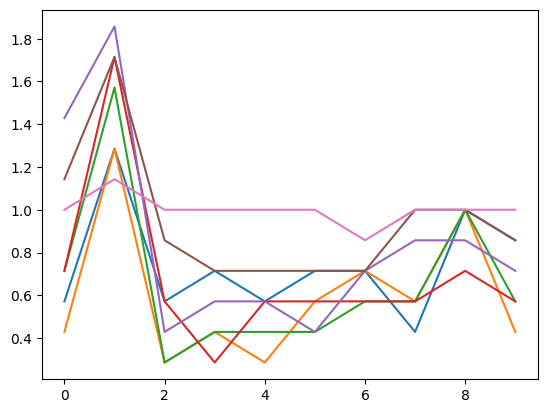

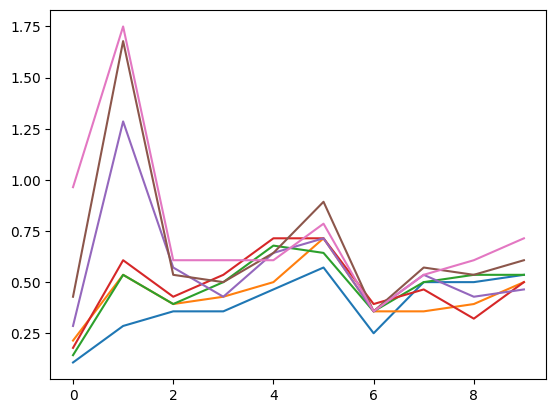

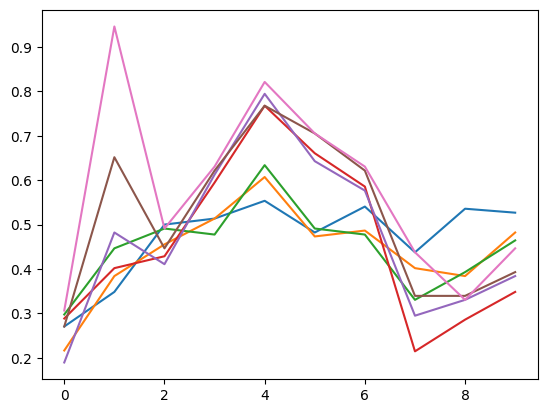

In [97]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((len(dsets), n_folds, len(ks)))

for i, (features, labels) in enumerate(dsets):
    print(f'Dataset size {len(labels)}')
    for j, item in enumerate(crossval_splits(features, labels, n_folds)):
        train_features, train_labels, val_features, val_labels = item
        for l, k in enumerate(ks):
            # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
            classif = KNeighborsClassifier(k)
            classif.fit(train_features.T, train_labels)
            errors[i, j, l] =  mean_err(classif.predict(val_features.T), val_labels)
            #scores[i, j, l] = 
for i in range(3):
    plt.plot(errors[i])
    plt.show()

In [ ]:
# TODO: make and interpret the plots as requested in the exercise
